Epoch 1/100
10/10 [==============================] - 3s 141ms/step - loss: 0.4170
Epoch 2/100
10/10 [==============================] - 1s 122ms/step - loss: 0.3146
Epoch 3/100
10/10 [==============================] - 1s 128ms/step - loss: 0.3429
Epoch 4/100
10/10 [==============================] - 1s 129ms/step - loss: 0.3374
Epoch 5/100
10/10 [==============================] - 1s 129ms/step - loss: 0.2981
Epoch 6/100
10/10 [==============================] - 1s 134ms/step - loss: 0.3175
Epoch 7/100
10/10 [==============================] - 1s 123ms/step - loss: 0.2986
Epoch 8/100
10/10 [==============================] - 2s 188ms/step - loss: 0.2960
Epoch 9/100
10/10 [==============================] - 2s 157ms/step - loss: 0.2788
Epoch 10/100
10/10 [==============================] - 2s 164ms/step - loss: 0.2924
Epoch 11/100
10/10 [==============================] - 2s 165ms/step - loss: 0.2346
Epoch 12/100
10/10 [==============================] - 2s 202ms/step - loss: 0.1531
Epoch 13/100


10/10 [==============================] - 2s 144ms/step - loss: 0.0315
Epoch 100/100
10/10 [==============================] - 2s 243ms/step - loss: 0.0315


<IPython.core.display.Javascript object>


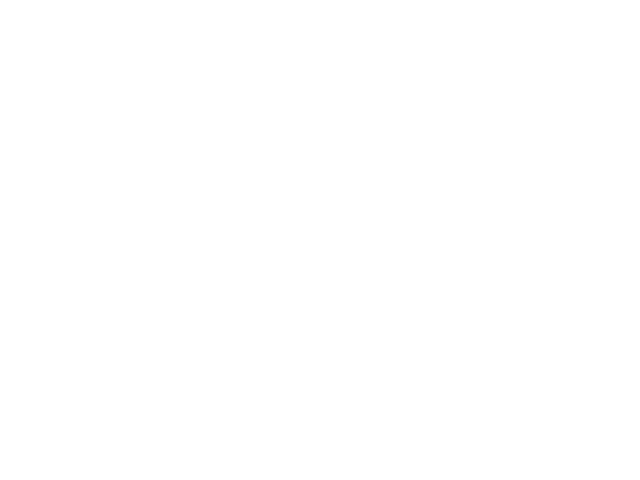

1/1 [==============================] - 1s 699ms/step
405
1/1 [==============================] - 0s 36ms/step
429
1/1 [==============================] - 0s 29ms/step
426


In [4]:
"""
    NN_RepresentativePoints_V7:
    
    This is the seventh attempt to "intelligently" decrease the resolution of images in a way that allows the original image
    to be reconstructed with minimal error. This was an attempt to implement V5 with convolution to provide spatial
    relations. The functional API is now used instead of inheriting from the Layers class for a cleaner result.
    
    Convolution applies an elementwise multiplication and subsequent sum of a matrix by an often much smaller matrix
    called a kernel. The kernel is like a stencil with a given shape. For an image, the value of a convolution at a given 
    point in the image is how similar the portion of the image covered by the stencil is when the stencil is centered over
    this point. For example, the sobel edge detection uses a kernel with form [-1, 0, 1] to detect if the zero is part of
    an edge (ie, if the left and right sides have significantly different magnitudes) and [1/3, 1/3, 1/3] acts as a blur. 
    This is what image processing essentially does, with different kernels. For neural networks, the values in the kernel
    are trainable like other nodes in the network. The network therefore learns the kernel that minimises the loss function.
    
    This version achieves much smoother results, and with better hyper-parameter tuning could perform well. Since kernels
    only have a specific area of affect, only with many layers can values be propogated over larger distances. This poses a
    particular issue when representative points are sufficiently sparse and the neural network not deep enough for values
    to be propogated to nearby regions, potentially resulting in some regions not being updated at all (and left with a 
    value of zero). This supports testing observations.
    
    Pros:
        Easily adjustable
        Generator allows training on synthesised data where real data is lacking
        Visualisation
        Limited range spatial relations provided by convolutions
        Differentiable Selector layer, which supposedly will assist backpropogation and allows @tf.function for speed-up
        Can weigh off the number of points selected against the reconstruction error (though need to tune hyperparameters here)
    Cons:
        poorish performance
        slower speed
        dropouts not included
        Not able to reliably "compress" over compressions (fixed format)
        selection tends to be the highest values in the image, indicating the selector is performing poorly
        results are clustered together, indicating that the top-k model selects areas of interest rather than individual points
    """
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, losses, initializers
import numpy as np
import PerlinNoiseReduced as pn
import matplotlib.pyplot as plt
import os

# "solves" matplotlib issues
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib notebook
        

class Representative_Points(Model):
    """
    This is the Model.
    
    Init:
        image_shape:                              The shape of the image
        kernel_size:                              The shape of the kernel
        rate:                                     The compression_rate
        kernel_init:                              How the kernel is initialised
    Params:
        inputs(num_batches, image_size):          The image
    Outputs:
        interpolation(num_batches, image_size):   The reconstructed image
    """    
    def __init__(self, image_shape, kernel_size, rate, kernel_init):
        super(Representative_Points, self).__init__()
        self.feature_layers = []
        self.selection_layers = []
        self.reconstruction_layers = []
        self.rate = rate
        self.image_shape = image_shape
        # Feature detection (convolutional layers)
        for i in range(10):
            self.feature_layers.append(layers.Conv2D(filters = 16, kernel_size = kernel_size, padding = 'same', activation = 'relu', name = f'Conv{i}', kernel_initializer = kernel_init))
            #self.feature_layers.append(layers.Normalization())
            #self.feature_layers.append(layers.Conv2DTranspose(filters = 16, kernel_size = kernel_size, padding = 'same', activation = 'relu', kernel_initializer = kernel_init))
            #self.feature_layers.append(layers.Normalization())
        # Pixel selection
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(image_shape.prod(), activation = 'relu', kernel_initializer = 'identity', name = 'dense')
        self.dense_select = layers.Dense(image_shape.prod(), activation = 'sigmoid', kernel_initializer = 'identity', name = 'dense')
        self.reshape = layers.Reshape(target_shape = image_shape)
        # Reconstruction (convolution tranpose layers)
        for i in range(10):
            self.reconstruction_layers.append(layers.Conv2DTranspose(filters = 16, kernel_size = kernel_size, padding = 'same', activation = 'relu', name = f'ConvT{i}', kernel_initializer = kernel_init))
            #self.feature_layers.append(layers.Normalization())
            #self.feature_layers.append(layers.Conv2D(filters = 16, kernel_size = kernel_size, padding = 'same', activation = 'relu', kernel_initializer = ConvolutionIdentity()))
            #self.feature_layers.append(layers.Normalization())
        self.reconstruction_layers.append(layers.Conv2DTranspose(filters = 1, kernel_size = kernel_size, padding = 'same', activation = 'relu', name = f'reconstruction', kernel_initializer = kernel_init))
        # reshaping for output
        self.reconstruction_layers.append(layers.Flatten())
        self.reconstruction_layers.append(layers.Dense(units = image_shape.prod(), name = 'reconstruction', kernel_initializer = 'identity'))
        self.reconstruction_layers.append(layers.Reshape(target_shape = image_shape))
        
    def call(self, inputs, training = None):
        x = inputs
        for layer in self.feature_layers:
            x = layer(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dense_select(x)
        mask = self.reshape(x)
        # the activation minimisation loss
        self.add_loss(0.00001*tf.nn.relu(tf.math.reduce_sum(tf.math.reduce_sum(x, axis = 1))-self.rate))
        x = layers.Multiply()((mask, inputs))
        for layer in self.reconstruction_layers:
            x = layer(x)
        return x if training else (mask, x)

class Generator(tf.keras.utils.Sequence):
    """
    A generator for data. This one generates it from the perlin noise generator.
    
    Init:
        image_shape:                              The shape of the output image
        max_epochs:                               The max number of epochs
        steps_per_epoch:                          How many training steps occur each epoch
        batch_size:                               The number of samples in a batch, defalulting to 32
    Outputs:
        ((images, bottlenecks),images):           A pair of training, testing results, where the training ones
                                                    are the input image and the desired number of representative 
                                                    points (bottleneck) and the testing one is the image to be 
                                                    used with mean squared error on the reconstructed image
    """
    def __init__(self, image_shape, max_epochs, steps_per_epoch, batch_size = 32):
        self.image_shape = image_shape
        self.noise = pn.PerlinNoise(image_shape)
        self.max_epochs = max_epochs
        self.steps_per_epoch = steps_per_epoch
        self.batch_size = batch_size
        
    def __len__(self):
        return self.max_epochs*self.steps_per_epoch
    
    def __getitem__(self, step):
        images = np.zeros(np.insert(self.image_shape, 0, self.batch_size))
        data_size = self.image_shape.prod()
        for b in range(self.batch_size):
            images[b] = self.noise.generate_fractal()
            images[b] = images[b]-np.min(images[b])
            images[b] = images[b]/np.max(images[b])
            #images[b] = (images[b]-np.mean(images[b]))/np.std(images[b])
            self.noise.reset()
        return (images,images)
    
# An initialiser such that the central pixel is a one and all others zeros
# Axes specifies which axes are treated dependently (ie, there is only one 1 in each of these axes)
# this was theorised to lead to better results as for the dense identity initialisation used in previous versions
class ConvolutionIdentity(initializers.Initializer):
    def __init__(self, axes = (0,1), cover = "glorot_uniform"):
        self.axes = axes
        self.cover = initializers.get(cover)

    def __call__(self, shape, dtype=tf.float32):
        base = self.cover(shape, dtype).numpy()
        slices = tuple([slice(dim) if axis not in self.axes else slice(int(np.floor(dim/2)), int(np.ceil(dim/2))) for axis, dim in enumerate(shape)])
        base[slices] = 2*np.max(base)
        return base

"""
    These are hyperparameters which are positioned together here for ease of change
    
    Variables:
        dim:                The dimension of the image
        BATCH_SIZE:         How many images are trained in parallel
        EPOCHS:             How many batches of images are used to train (~training steps)
        rate:               The desired compression rate
        kernel_size:        The shape of the kernel
"""

dim = 30
image_shape = np.array((dim,dim, 1))
BATCH_SIZE = 8
EPOCHS = 100
STEPS_PER_EPOCH = 10
rate = dim
kernel_size = (5,5)
kernel_init = 'glorot_uniform'#ConvolutionIdentity()

# model initialisaton
model = Representative_Points(image_shape, kernel_size, rate, kernel_init)
model.compile(optimizer = "Adam", loss = losses.MeanSquaredError(), run_eagerly = False)

data = Generator(image_shape, max_epochs = EPOCHS, steps_per_epoch = STEPS_PER_EPOCH, batch_size = BATCH_SIZE)

model.fit(
    x=data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)],
    steps_per_epoch=STEPS_PER_EPOCH,
    verbose = 1)

#model.save("model.h5")

# visualisation
number = 3
noise = pn.PerlinNoise(image_shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.meshgrid(np.arange(0, image_shape[0]), np.arange(0, image_shape[1]))
for index in range(number):
    img = noise.generate_fractal()
    img = (img-np.mean(img))/np.std(img)
    reps, output = model.predict(img[np.newaxis])
    # remove batching and extra feature layers
    reps, output, img = reps[0,:,:,0], output[0,:,:,0], img[:,:,0]
    reps = reps*img
    elim = reps > 0.1
    print(elim.sum())
    
    ax = fig.add_subplot(3, number, index + 1, projection = "3d")
    #ax.set_zlim(bottom = -2)
    ax.plot_surface(x, y, img)
    ax.scatter(x[elim], y[elim], reps[elim], c = "r")
    
    ax = fig.add_subplot(3, number, number + index + 1, projection = "3d")
    #ax.set_zlim(bottom = -2)
    ax.plot_surface(x, y, output)
    ax.scatter(x[elim], y[elim], reps[elim], c = "r")
    
    ax = fig.add_subplot(3, number, 2*number + index + 1, projection = "3d")
    ax.plot_surface(x, y, img-output)